## 1. 概要

- データセットを作成するための計算を行った
  - SHGの変換効率について、近似解と解析解を計算して比較した
- 導波路に対してもpythonで計算ができるようにWGMODESをpythonに移植した

## 2. 計算

### SHG変換効率の解析解

- 変換効率は以下の式で表される。
$$
\eta = \frac{|B(L)|^2}{|A(0)|^2}
$$
  - $A(z)$ は入射光の振幅である。
  - $B(z)$ はSH光の振幅である。

- $A(z)$ と $B(z)$ は、以下の連立微分方程式を満たす。
$$
\frac{d}{dz}A(z) = -j\kappa^* A^*(z)B(z) \exp(j(2\Delta z))
$$
$$
\frac{d}{dz}B(z) = -j\kappa A(z)^2 \exp(j(2\Delta z))
$$

ただし、$\kappa$ および $2\Delta$ は次の式で定義される。

$$
\kappa^{(q)}_{NL} = \frac{2\omega \varepsilon_0}{4} \iint \left[ E^{2\omega}(x, y) \right]^* \mathbf{d_q}(x, y) \left[ E^{\omega}(x, y) \right]^2 dx\,dy
$$
$$
2\Delta^{(q)}_{SHG} = \beta^{2\omega} - \left( 2\beta^{\omega} + qK \right)
$$

ここで、$q$ はQPMの次数であり、通常は1次である。

- $L$ を変化させたグラフ

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from syuron import shg

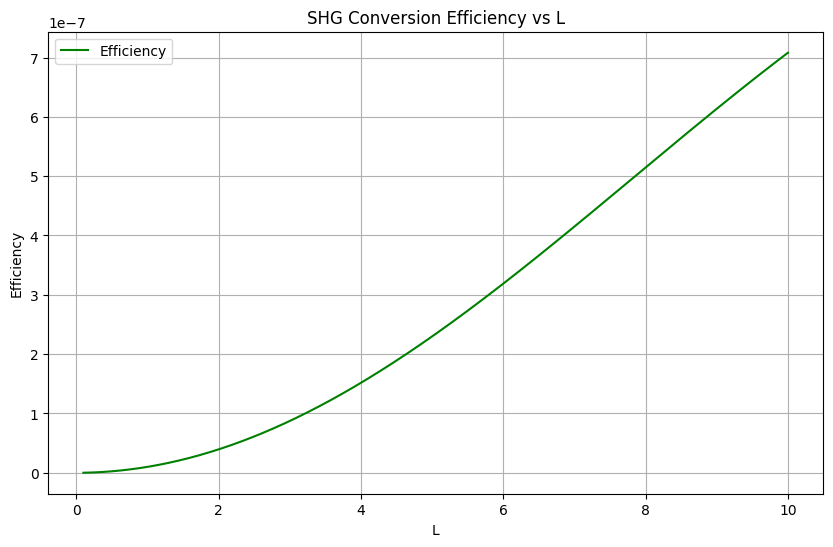

In [57]:
def L_vs_eff():
    # kappaとtwodelta関数の定義
    def kappa(z: float) -> complex:
        return 0.0001  # 小さい値を設定

    def twodelta(z: float) -> float:
        return 0.2

    # パラメータ設定
    A0 = 1.0 + 0j  # Initial condition for A(0)
    B0 = 0.0 + 0j  # Initial condition for B(0)
    L_values = np.linspace(0.1, 10, 600)

    # NMCEオブジェクトの作成
    nmce = shg.NMCE(kappa, twodelta)

    # 効率計算
    efficiency_values = []
    for L in L_values:
        B_L, A_z = nmce.solve(L, A0, B0)
        efficiency = shg.efficiency(B_L, A0)  # 効率を計算
        efficiency_values.append(efficiency)  # 効率をリストに追加

    return L_values, efficiency_values


# 効率を計算
L_approx, eff_vals = L_vs_eff()

# グラフの描画
plt.figure(figsize=(10, 6))

# Lに対する効率のプロット
plt.plot(L_approx, eff_vals, label='Efficiency', color='green')

plt.title('SHG Conversion Efficiency vs L')
plt.xlabel('L')
plt.ylabel('Efficiency')
plt.legend()
plt.grid()
plt.show()

* $\Delta$を変化させたグラフ

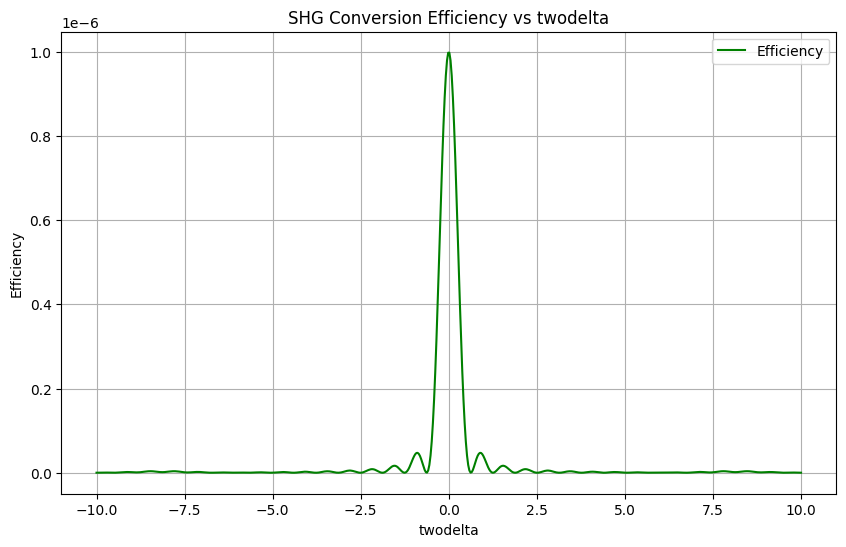

In [58]:
def twodelta_vs_eff():
    # kappa 関数の定義
    def kappa(z: float) -> complex:
        return 0.0001  # 小さい値を設定

    # パラメータ設定
    A0 = 1.0 + 0j  # A(0) の初期条件
    B0 = 0.0 + 0j  # B(0) の初期条件
    L = 10  # L を固定
    twodelta_values = np.linspace(-10, 10, 600)

    # 効率計算
    efficiency_values = []
    for twodelta_value in twodelta_values:
        # twodelta(z) 関数を定義（z に依存しない定数を返す）
        def twodelta(z: float) -> float:
            return twodelta_value

        # NMCE オブジェクトの作成
        nmce = shg.NMCE(kappa, twodelta)

        # 効率計算
        B_L, A_z = nmce.solve(L, A0, B0)
        efficiency = shg.efficiency(B_L, A0)  # 効率を計算
        efficiency_values.append(efficiency)  # 効率をリストに追加

    return twodelta_values, efficiency_values


# 効率を計算
twodelta_vals, eff_vals = twodelta_vs_eff()

# グラフの描画
plt.figure(figsize=(10, 6))

# twodelta に対する効率のプロット
plt.plot(twodelta_vals, eff_vals, label='Efficiency', color='green')

plt.title('SHG Conversion Efficiency vs twodelta')
plt.xlabel('twodelta')
plt.ylabel('Efficiency')
plt.legend()
plt.grid()
plt.show()

### 近似解

$\kappa$と$\Delta$が小さい時、変換効率が小さく、変換効率が小さい時以下のように近似できる

$$
\eta = \kappa^2 P_0 L^2 \left( \frac{\sin (\Delta L)}{\Delta L} \right)^2
$$

- $L$を変化させたグラフ

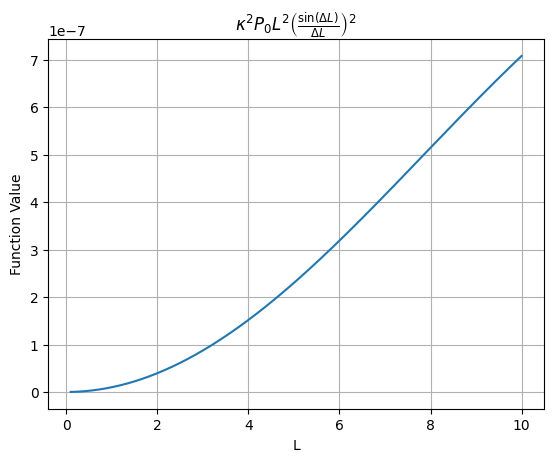

In [59]:
def L_vs_eff_approx():
    kappa = 0.0001  # 小さい値を設定
    Delta = 0.1  # twodeltaの半分の値を設定
    A0 = 1.0
    P_0 = A0**2

    # Lの範囲を定義
    L = np.linspace(0.1, 10, 1000)

    # 近似関数
    def function(L, kappa, P_0, Delta):
        return kappa**2 * P_0 * L**2 * (np.sin(Delta * L) / (Delta * L))**2

    y_values = function(L, kappa, P_0, Delta)

    return L, y_values


L_approx, y_vals_approx = L_vs_eff_approx()

plt.plot(L_approx, y_vals_approx)
plt.xlabel('L')
plt.ylabel('Function Value')
plt.title(
    r'$\kappa^2 P_0 L^2 \left( \frac{\sin (\Delta L)}{\Delta L} \right)^2$')
plt.grid(True)
plt.show()

* $\Delta$を変化させたグラフ

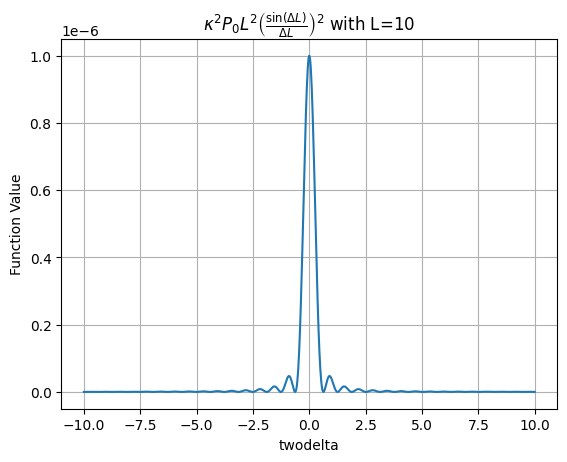

In [60]:
def twodelta_vs_eff_approx():
    kappa = 0.0001  # 小さい値を設定
    L = 10  # Lを固定
    A0 = 1.0
    P_0 = A0**2

    # twodeltaの範囲を定義
    twodelta = np.linspace(-10, 10, 1000)

    # 近似関数
    def function(twodelta, kappa, P_0, L):
        Delta = twodelta / 2  # Deltaをtwodeltaの半分に設定
        return kappa**2 * P_0 * L**2 * (np.sin(Delta * L) / (Delta * L))**2

    y_values = function(twodelta, kappa, P_0, L)

    return twodelta, y_values


twodelta_vals_approx, y_vals_approx = twodelta_vs_eff_approx()

plt.plot(twodelta_vals_approx, y_vals_approx)
plt.xlabel('twodelta')
plt.ylabel('Function Value')
plt.title(
    r'$\kappa^2 P_0 L^2 \left( \frac{\sin (\Delta L)}{\Delta L} \right)^2$ with L=10')
plt.grid(True)
plt.show()

### 近似解と解析解の比較

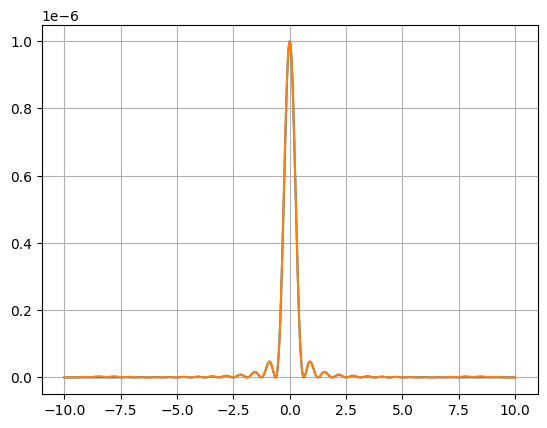

In [61]:
plt.plot(*twodelta_vs_eff_approx())
plt.plot(*twodelta_vs_eff())
plt.grid(True)
plt.show()

## 3. 次にやること

* データセットを作成する
